### Imports

In [1]:
import cv2
import time

import numpy as np
import matplotlib.pyplot as plt


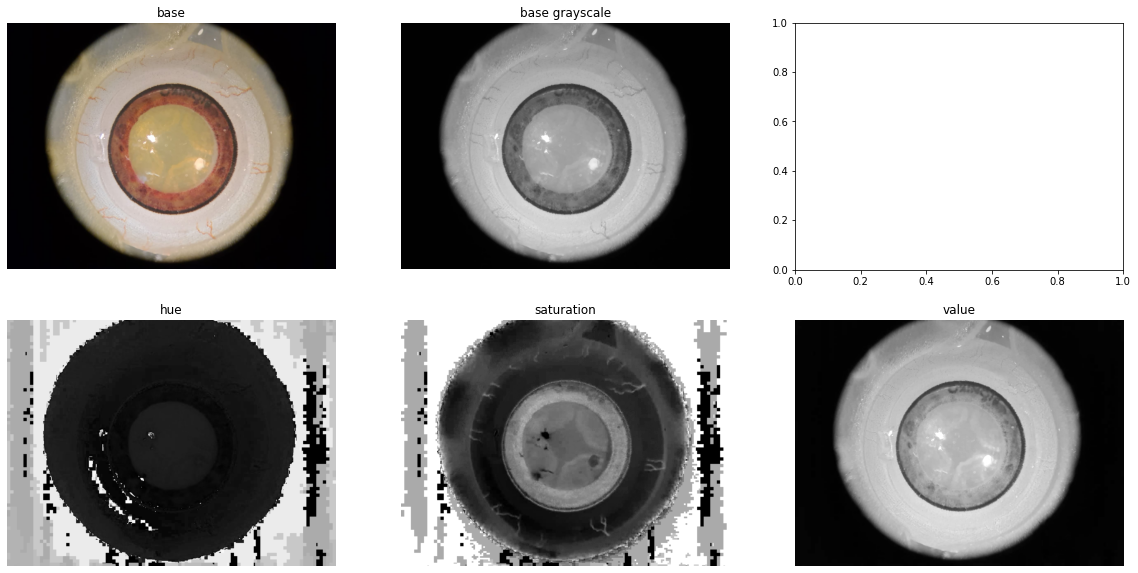

In [2]:
base = cv2.imread('data/artificial/base1.jpeg', cv2.IMREAD_COLOR)
base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:,:,0]
base_saturation = base_hsv[:,:,1]
base_value = base_hsv[:,:,2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)) = plt.subplots(2, 3, figsize=(20,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

In [3]:
scale = 0.4
base_gray_small = cv2.resize(base_gray, (0,0), fx=scale, fy=scale)
base_gray_small.shape

(480, 640)

In [4]:
def get_tuple_point(array_point):
    return tuple(np.round(array_point).astype('int'))

In [5]:
def detect_circle(gray, return_all=False):
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=1,
        param1=120, param2=40,
        minRadius=gray.shape[0]//10, maxRadius=round(gray.shape[0]//1.5)
    )
    
    if circles is None:
        return None
    
    if return_all:
        return circles[0,:,:]

    return circles[0,0,:2], circles[0,0,2]

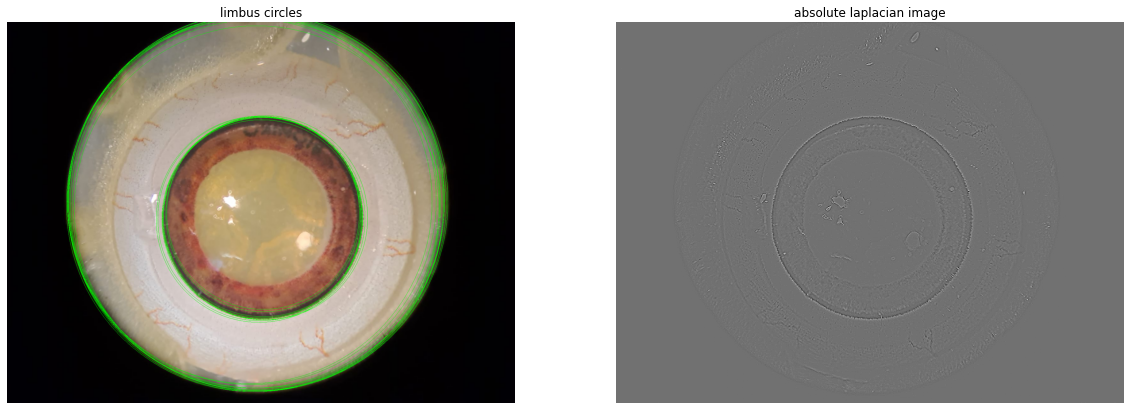

In [6]:
circles = detect_circle(base_gray_small, return_all=True)

base_copy = base_rgb.copy()
for circle in circles[:20,:]:
    limbus_center = circle[:2] / scale
    limbus_radius = circle[2] / scale

#     cv2.drawMarker(base_copy, get_tuple_point(limbus_center), (0,255,0))
    cv2.circle(base_copy, get_tuple_point(limbus_center), round(limbus_radius), (0,255,0), thickness=1)

fig, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title('limbus circles')
plots[0].imshow(base_copy)
plots[0].axis('off')

plots[1].set_title('absolute laplacian image')
# plots[1].imshow(np.abs(cv2.Laplacian(base_gray_small, cv2.CV_16S)), cmap=plt.cm.gray)
plots[1].imshow(cv2.Laplacian(255 - base_gray_small, cv2.CV_16S), cmap=plt.cm.gray)
plots[1].axis('off')

plt.show()

In [7]:
def get_mean_laplacian(laplacian, center, radius):
    mask = np.zeros(laplacian.shape, dtype=np.byte)
    cv2.circle(mask, center, radius, 1)
    return np.mean(laplacian[mask == 1])

In [8]:
def get_std_laplacian(laplacian, center, radius):
    mask = np.zeros(laplacian.shape, dtype=np.byte)
    cv2.circle(mask, center, radius, 1)
    return np.std(laplacian[mask == 1])

In [9]:
circle_width_to_radius_ratio = 0.05

def get_mean_intensity(grey, center, radius):
    mask = np.zeros(grey.shape, dtype=np.byte)
    circle_width = int(circle_width_to_radius_ratio*radius)
    cv2.circle(mask, center, radius + (circle_width//2), 1, thickness=circle_width)
    return np.mean(grey[mask == 1])

In [10]:
circle_width_to_radius_ratio = 0.04

def get_in_out_intensity_diff(grey, center, radius):
    mask = np.zeros(grey.shape, dtype=np.byte)
    circle_width = int(circle_width_to_radius_ratio*radius)
    
    cv2.circle(mask, center, radius - (circle_width//2), 1, thickness=circle_width)
    in_intensity = np.mean(grey[mask == 1])
    
    cv2.circle(mask, center, radius + (circle_width//2), 1, thickness=circle_width)
    out_intensity = np.mean(grey[mask == 1])
    
    return out_intensity - in_intensity

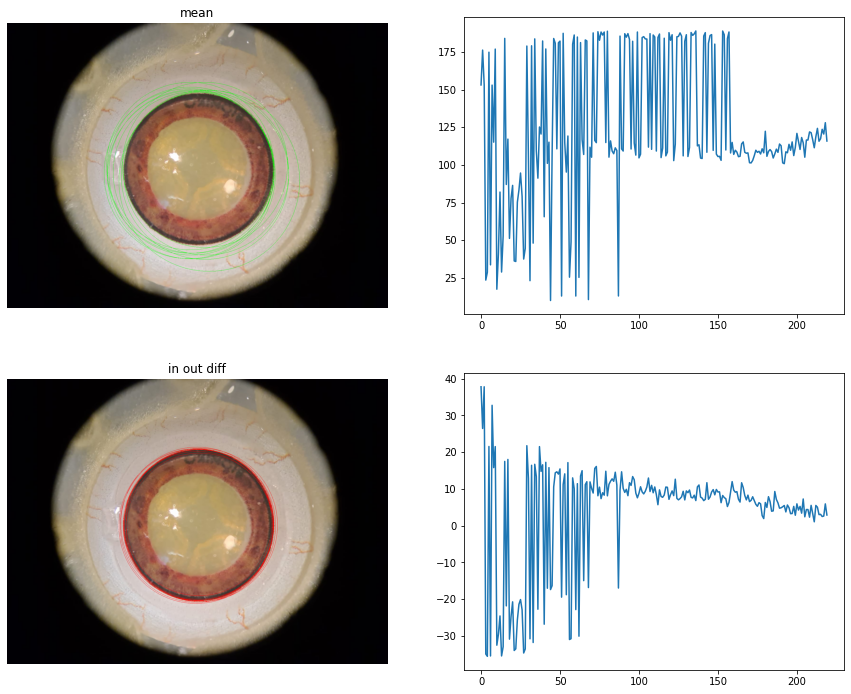

In [163]:
circles = detect_circle(base_gray_small, return_all=True)

mean_intensity = np.zeros(circles.shape[0])
in_out_intensity_diff = np.zeros(circles.shape[0])
for index, circle in enumerate(circles):
    limbus_center = get_tuple_point(circle[:2])
    limbus_radius = np.round(circle[2]).astype('int')
    mean_intensity[index] = get_mean_intensity(base_gray_small, limbus_center, limbus_radius)
    in_out_intensity_diff[index] = get_in_out_intensity_diff(base_gray_small, limbus_center, limbus_radius)

base_copy_mean = base_rgb.copy()
interesting_indices = np.argsort(mean_intensity)[-10:]
for index in interesting_indices:
    circle = circles[index]
    
    limbus_center = get_tuple_point(circle[:2] / scale)
    limbus_radius = np.round(circle[2] / scale).astype('int')
    cv2.circle(base_copy_mean, limbus_center, limbus_radius, (0,255,0), thickness=1)
    
base_copy_in_out = base_rgb.copy()
interesting_indices = np.argsort(in_out_intensity_diff)[-10:]
for index in interesting_indices:
    circle = circles[index]
    
    limbus_center = get_tuple_point(circle[:2] / scale)
    limbus_radius = np.round(circle[2] / scale).astype('int')
    cv2.circle(base_copy_in_out, limbus_center, limbus_radius, (255,0,0), thickness=1)

fig, plots = plt.subplots(2, 2, figsize=(15,12))
plots[0][0].set_title('mean')
plots[0][0].imshow(base_copy_mean)
plots[0][0].axis('off')

plots[0][1].plot(range(mean_intensity.shape[0]), mean_intensity)

plots[1][0].set_title('in out diff')
plots[1][0].imshow(base_copy_in_out)
plots[1][0].axis('off')

plots[1][1].plot(range(mean_intensity.shape[0]), in_out_intensity_diff)

plt.show()